In [2]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [3]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, GLM
import PyPlot; const plt = PyPlot ;

In [4]:
validation_data_saft_vr_mie = CSV.read("saft_vr_mie_validation_data.csv",DataFrame)
num_rows = nrow(validation_data_saft_vr_mie)

rename!(validation_data_saft_vr_mie,:sat_t_K_clapeyron=>:sat_temp_strings, :sat_p_MPa_clapeyron=>:sat_pressure_strings,
        :sat_vliq_m3_per_mol_clapeyron=>:sat_vol_liq_strings,:sat_vvap_m3_per_mol_clapeyron=>:sat_vol_vap_strings)

# Define the column names
array_cols_to_create = [:sat_t_K_clapeyron, :sat_p_MPa_clapeyron, :sat_vliq_m3_per_mol_clapeyron, :sat_vvap_m3_per_mol_clapeyron]
string_columns = [:sat_temp_strings, :sat_pressure_strings, :sat_vol_liq_strings, :sat_vol_vap_strings]

# Initialize the columns with zeros
for col in array_cols_to_create
    validation_data_saft_vr_mie[!, col] .= fill([0.0], num_rows)
end

# Process and assign the values to the DataFrame
for (col, str_col) in zip(array_cols_to_create, string_columns)
    for i = 1:num_rows
        string_sq_brackets_removed = replace(validation_data_saft_vr_mie[i, str_col], r"[][]" => "")
        vector_of_floats = [parse(Float64, val) for val in split(string_sq_brackets_removed, ",")]
        validation_data_saft_vr_mie[i, col] = vector_of_floats
    end
end

# Remove the string columns
select!(validation_data_saft_vr_mie, Not(string_columns...));

validation_data_saft_vr_mie;

In [5]:
# # Define the custom order of values
# custom_order = Dict("Methane" => 1, "Value2" => 2, "Value3" => 3, "Value4" => 4)

# # Create a comparison function based on the custom order
# function custom_compare(x, y)
#     return custom_order[x] < custom_order[y]
# end

# # Sort the DataFrame based on the custom comparison function
# sort!(df, :column_to_sort, lt=custom_compare)

# # Display the sorted DataFrame
# println(df)

In [6]:
# Species to filter
species_to_filter = ["methane", "ethane","n-propane","n-butane","n-pentane","n-hexane","n-heptane","n-octane","n-nonane","n-decane"]

# Filter based on species
validation_data_saft_vr_mie_linear_alkanes = filter(row -> lowercase(row.species) in species_to_filter, validation_data_saft_vr_mie) ;


In [7]:
function r_squared(y_actual, y_predicted)
    mean_actual = sum(y_actual)/length(y_actual)
    total_ss = sum((y_actual .- mean_actual).^2)
    residual_ss = sum((y_actual .- y_predicted).^2)
    r2 = 1.0 - residual_ss / total_ss
    return r2
end

m_sigmacubed = []
m_epsilon = []

ideal_Mw = collect(range(0,200))
linear_alkanes_Mw = validation_data_saft_vr_mie_linear_alkanes.Mw

for (a, b) in zip(validation_data_saft_vr_mie_linear_alkanes.segment, validation_data_saft_vr_mie_linear_alkanes.sigma)
    push!(m_sigmacubed, a*b^3)
end

for (a, b) in zip(validation_data_saft_vr_mie_linear_alkanes.segment, validation_data_saft_vr_mie_linear_alkanes.epsilon)
    push!(m_epsilon, a*b)
end

lin_fit_coeff_mσ3 = coef(lm(@formula(m_sigmacubed ~ linear_alkanes_Mw), DataFrame(linear_alkanes_Mw = Float64.(linear_alkanes_Mw),m_sigmacubed = Float64.(m_sigmacubed))))
lin_fit_coeff_mϵ = coef(lm(@formula(m_epsilon ~ linear_alkanes_Mw), DataFrame(linear_alkanes_Mw = Float64.(linear_alkanes_Mw),m_epsilon = Float64.(m_epsilon))));

ideal_mσ3 = [lin_fit_coeff_mσ3[1] + lin_fit_coeff_mσ3[2]*i for i in ideal_Mw]
ideal_mϵ = [lin_fit_coeff_mϵ[1] + lin_fit_coeff_mϵ[2]*i for i in ideal_Mw]

ideal_mσ3_for_r2 = [lin_fit_coeff_mσ3[1] + lin_fit_coeff_mσ3[2]*i for i in linear_alkanes_Mw]
ideal_mϵ_for_r2 = [lin_fit_coeff_mϵ[1] + lin_fit_coeff_mϵ[2]*i for i in linear_alkanes_Mw] ;

# Compute R^2
r2_mσ3 = r_squared(m_sigmacubed, ideal_mσ3_for_r2)
r2_mϵ = r_squared(m_epsilon, ideal_mϵ_for_r2)

# Display the result
println(lin_fit_coeff_mσ3)
println("R\$^2\$ value mσ3: ", r2_mσ3)

println(lin_fit_coeff_mϵ)
println("R\$^2\$ value mϵ: ", r2_mϵ)

[18.2780770070087, 1.8975128069907474]
R$^2$ value mσ3: 0.9996083045458773
[36.24515843345274, 8.203422340681593]
R$^2$ value mϵ: 0.9995066114384469


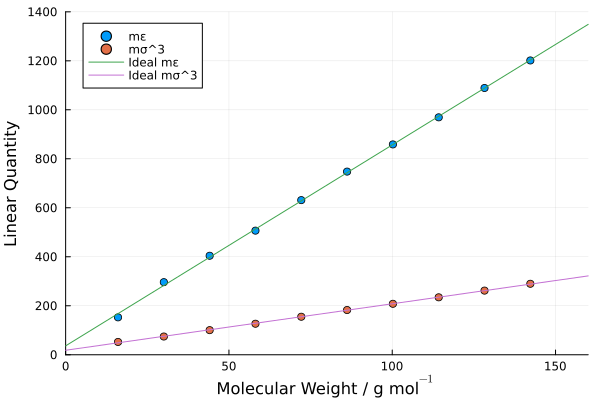

In [18]:
using Plots

# Set the backend (choose the appropriate backend for your needs)
# gr(size=(800, 800), dpi=400)

scatter(linear_alkanes_Mw, m_epsilon, label="mε")
scatter!(linear_alkanes_Mw, m_sigmacubed, label="mσ^3")
plot!(ideal_Mw, ideal_mϵ, label="Ideal mε")
plot!(ideal_Mw, ideal_mσ3, label="Ideal mσ^3")

xlabel!("Molecular Weight / g mol\$^{-1}\$", fontsize=18, font="serif")
ylabel!("Linear Quantity", fontsize=18, font="serif")
# legend(loc="upper left", fontsize=14)
# xticks!(fontsize=14, font="serif")
# yticks!(fontsize=14, font="serif")

# title!("Linear Alkane SAFT-VR Mie Parameter Combinations", fontsize=14)
xlims!(0, 160)
ylims!(0, 1400)


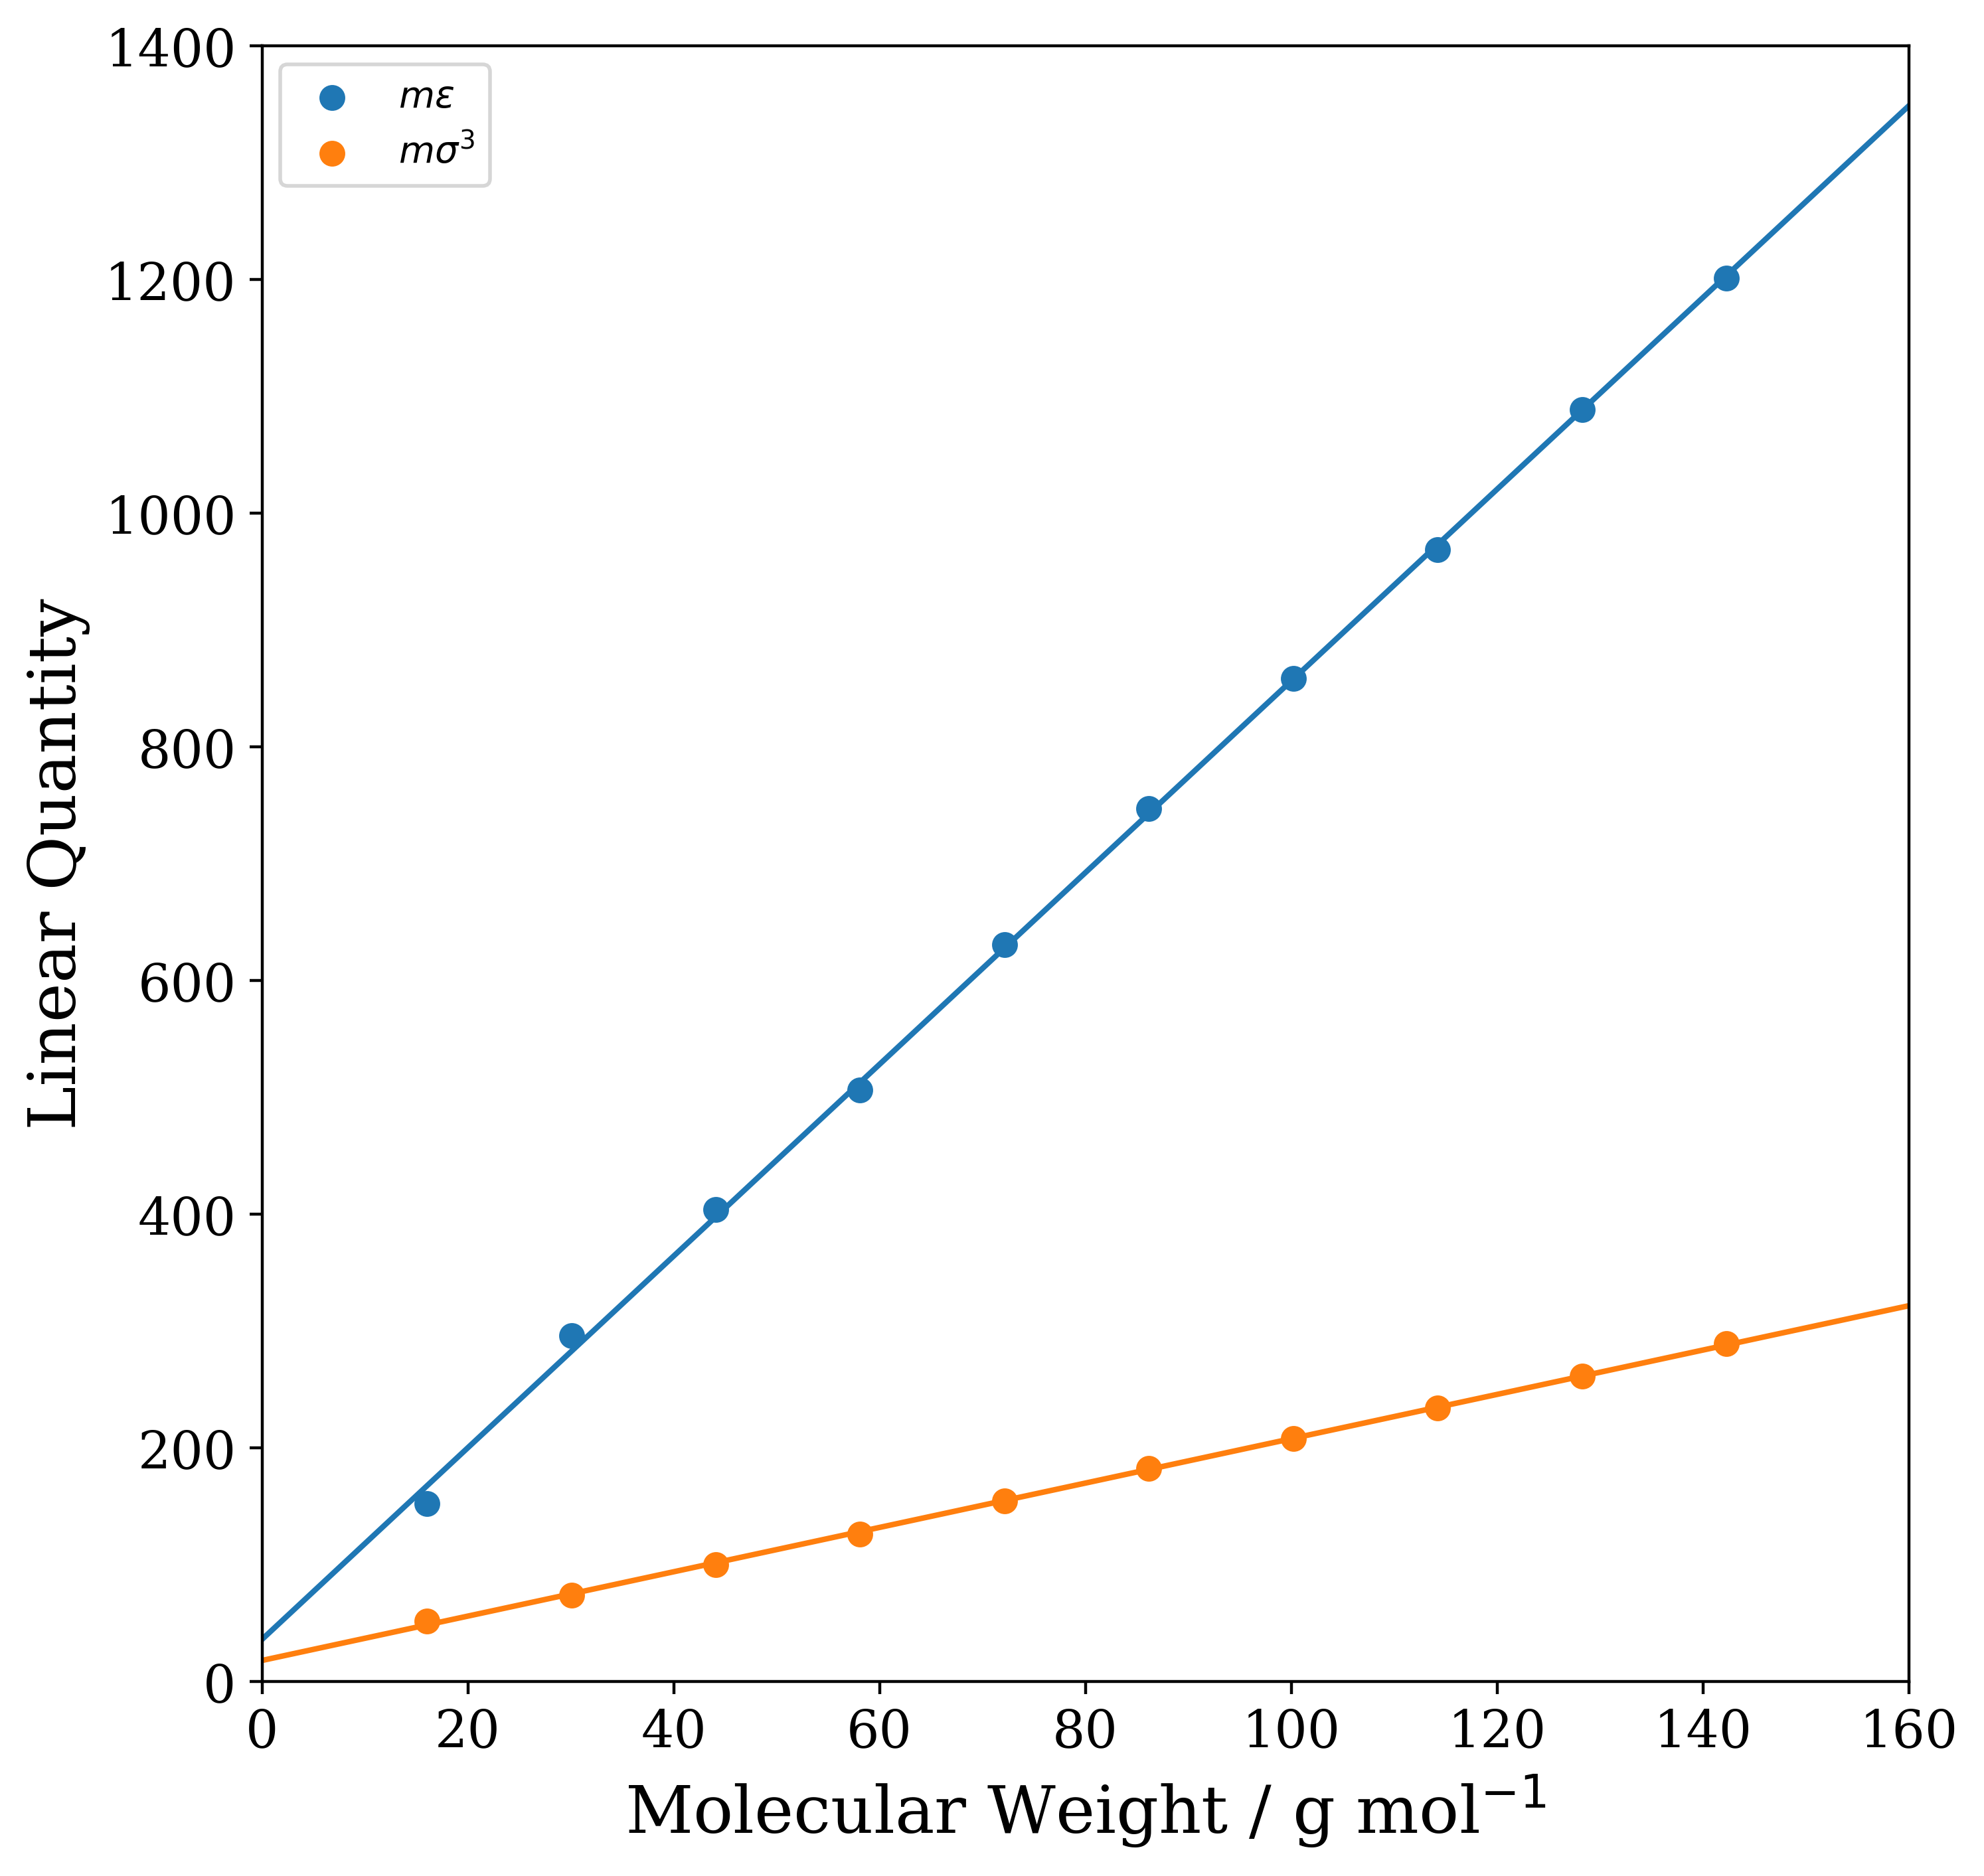

(0.0, 1400.0)

In [13]:
using Plots

plt.figure(figsize=(8, 8), dpi=400)

plt.scatter(linear_alkanes_Mw, m_epsilon, label="mε")
plt.scatter(linear_alkanes_Mw, m_sigmacubed, label="mσ^3")
plt.plot(ideal_Mw, ideal_mϵ)
plt.plot(ideal_Mw, ideal_mσ3)

plt.xlabel("Molecular Weight / g mol\$^{-1}\$",fontsize=18,font="serif")
plt.ylabel("Linear Quantity",fontsize = 18,font="serif")
plt.legend(["\$mε\$","\$mσ^3\$"],loc="upper left")
plt.xticks(fontsize=14, fontname="serif")
plt.yticks(fontsize=14, fontname="serif")

# plt.title("Linear Alkane SAFT-VR Mie Parameter Combinations",fontsize=14)
plt.xlim(0,160)
plt.ylim(0,1400);

# plt.savefig("Linear_Quantities_SAFT_VR_Mie.svg")